<div align="center">
    
## 다양한 OCR모델 비교하기    
</div>

#### 주요 라이브러리 버전체크

In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


#### importing the libraries

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [5]:
path = os.getenv('HOME') + '/aiffel/ocr_python/invoice/'

In [6]:
image_name = [
    'invoice01.png',
    'invoice02.png',
    'invoice03.png',
    'invoice04.jpg',
    'invoice05.jpg',
    'invoice06.jpg'
]

In [8]:
image_path = []

for i in image_name:
    img = path + i
    image_path.append(img)

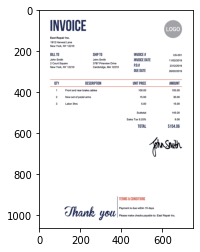

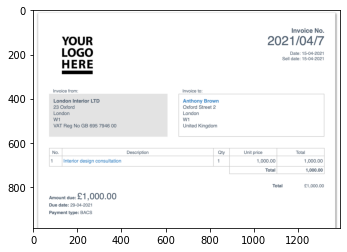

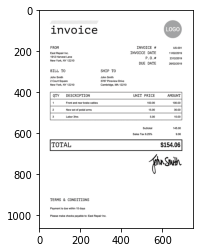

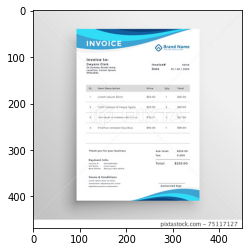

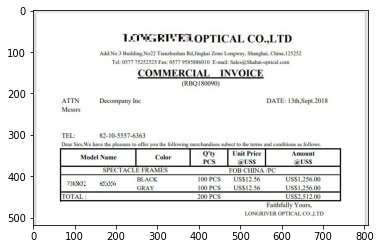

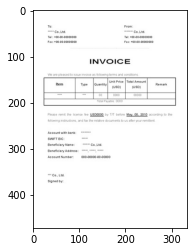

In [9]:
for img in image_path:
    img_bgr = cv2.imread(img)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

In [30]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [31]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
# path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

E0303 08:55:13.518044590     336 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1646297713.517981854","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1646297713.517978029","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
-rw-r--r-- 1 root root 2332 Mar  3 08:47 /aiffel/aiffel/ocr_python/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #964679342948 by visiting https://console.developers.google.com/billing/enable?project=964679342948 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry. [links {
  description: "Google developers console billing"
  url: "https://console.developers.google.com/billing/enable?project=964679342948"
}
, reason: "BILLING_DISABLED"
domain: "googleapis.com"
metadata {
  key: "consumer"
  value: "projects/964679342948"
}
metadata {
  key: "service"
  value: "vision.googleapis.com"
}
]

#### keras-ocr

**keras_ocr.pipeline.Pipeline()**

- 인식을 위한 파이프라인 생성

In [32]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드 받게 됩니다.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [33]:
images = [keras_ocr.tools.read(image) for image in image_path]
prediction_groups = [pipeline.recognize([image]) for image in image_path] 

#### visualization

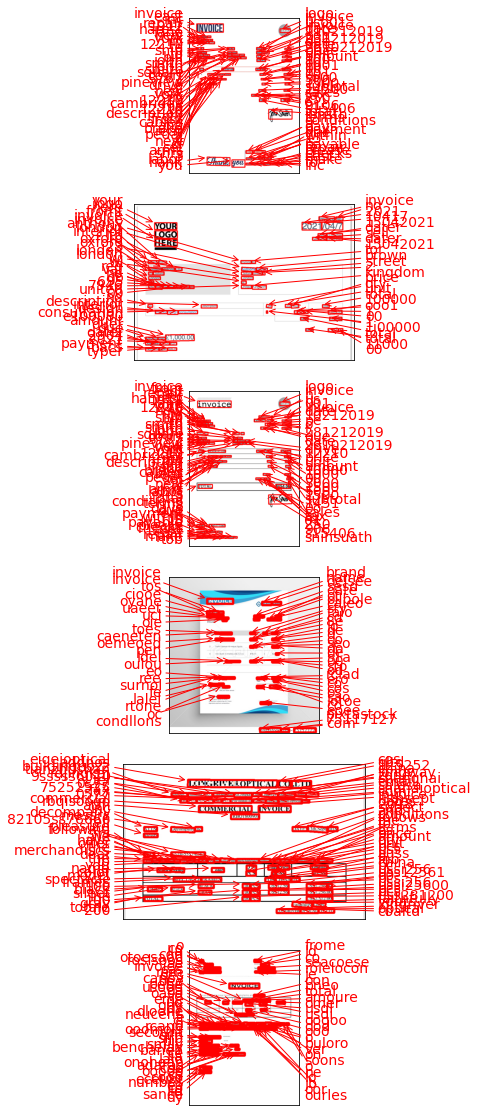

In [34]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20,20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx],
                                   predictions=prediction_groups[idx][0], ax=ax)

#### Tesseract

In [36]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [37]:
crop_file_path = [
    'invoice01.png',
    'invoice02.png',
    'invoice03.png',
    'invoice04.jpg',
    'invoice05.jpg',
    'invoice06.jpg'
]

In [38]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/invoice'

cropped_image_total = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[]}

for i in range(6):
    work_dir_sub = work_dir+crop_file_path[i]
    cropped_image_path_list = crop_word_regions(image_path[i], work_dir_sub)
    cropped_image_total[i+1].append(cropped_image_path_list)

/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0000.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0001.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0002.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0003.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0004.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0005.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0006.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0007.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0008.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0009.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0010.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0011.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0012.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0013.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0014.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0015.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0016.png
/aiffel/aiffel/ocr_python/invoiceinvoice01.png/0

/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0000.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0001.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0002.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0003.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0004.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0005.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0006.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0007.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0008.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0009.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0010.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0011.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0012.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0013.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0014.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0015.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0016.png
/aiffel/aiffel/ocr_python/invoiceinvoice03.png/0

/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0000.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0001.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0002.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0003.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0004.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0005.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0006.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0007.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0008.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0009.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0010.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0011.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0012.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0013.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0014.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0015.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0016.png
/aiffel/aiffel/ocr_python/invoiceinvoice06.jpg/0

Tesseract로 잘린 이미지에서 단어 인식

In [40]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")
    
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for i in range(1,7):
    print('------{}번째 invoice------'.format(i))
    cropped_image_path_list = cropped_image_total[i][0]
    recognize_images(cropped_image_path_list)

------1번째 invoice------
INVOICE

- act

Repair

inc.

1917

riarvest

| ane

New

York,

NY

172710

RR

ccc nccacncncccccccaccaccaaencccncccncncaccracraccacccacncnccccnccenccccccccccccccncnacccacnccccccccccaccaarn acne.

BILLTO

SHIP

TU

NVUILE

i

US-0071

Jonn

Smith

JOnry

Smith

NVUILE

DATE

11/02/2019

7

Court

Square

S/6F

rineview

Urive

Pi) Ft

New

York,

wy

122710

Cambnage,

VILA,

12710

. >

2317/2019

DUE

DATE

26/07/2019

ay

DESCRIPTION

UNIT

PRICE

AMOUNT

1

rront

and

fear

brake

cables

100.00

100.00

2

New set of pedal

of

»edal

aritis

15.00

30.00

3

| abor

Shrs

5.00

15 00

‘Subtotal

145.00

Sales

Tax

6.25%

9 O06

TOTAL

$154.06

Oth

TERMS

fy

CONDITIONS

Payment

is

due

within

15

days

CJ

Shank

you

Hea ce

make

cnecks

payable to:

> cf

Repair

Done
------2번째 invoice------
YOUR

1OGO

HERE

invoice

tTrom:

| onaon

interior


## 회고

: google api는 결제 카드 등록을 안 해서 오류코드가 발생했다.

에펠을 하면 할수록 느끼는 게 뭔가 계속 헛도는 느낌이다.

나 스스로가 함수를 정의할 코딩 능력이 있는 것도 아니고, 데이터를 보고 전처리를 어떻게 해야 하는지, 어떤 접근 방식으로 접근해서 어떤 모델을 써야 하는지 튜닝을 어떻게 해야 하는지,,,,, 배우면 배울수록 감이 안 잡히는 느낌이다. 나의 공부 방법이 잘못된 건지 나의 이해 능력이 부족한 건지 갈피를 못 잡겠다. 그냥 에펠에서 알려주는 대로 따라 하기 급급해서 코드를 이해하는 부분, 이 모델을 쓰면 이런 부분에서 좋은 건가 하는 막연한 심증 이런 것들이 점점 쌓여가서 앞으로 어떤 식으로 방향을 잡고 공부를 해야 하는지 막막해진다. 하면 할수록 이런 부분들이 크게 자리 잡혀 이번 회고는 그 과정보다는 나 스스로에 대한 회고로 작성하게 되었다. 그냥 따라 하는 것밖에 할 수가 없어서 그냥 내가 어림짐작 이해한 부분을 프젝 과정에 담기에도 애매해서 그냥 코드 제출식으로 프젝을 마무리한다. 앞으로 방향성을 다시 잡아야 할 것 같다. 